In [40]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator


5.7.1


In [41]:
#linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
#linkRates
linkRates = pd.read_csv('linRates_V9.csv')
linkRates=linkRates.iloc[:,1:len(linkRates)]
linkRates


#Elink ve Slink'in ne?

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
0,0,296.6600,9.0,1,2.500000,0.000000,296.0,2,False,9.493120,1054.791111
1,1,83.4939,3.0,1,4.000000,0.000000,320.0,1,False,2.671805,890.601600
2,2,142.4875,5.0,1,6.500000,0.000000,360.0,4,False,4.559600,911.920000
3,3,240.4057,7.0,1,4.666667,1.333333,332.0,3,False,7.692982,1098.997486
4,4,122.4558,4.0,1,7.500000,1.000000,377.0,4,False,3.918586,979.646400
...,...,...,...,...,...,...,...,...,...,...,...
1352,2163,27.4491,5.0,50,15.000000,7.000000,13047.0,1,False,0.878371,175.674240
1353,2164,27.4549,5.0,50,15.000000,8.000000,13048.0,1,False,0.878557,175.711360
1354,2165,27.4438,5.0,50,15.000000,9.000000,13049.0,1,False,0.878202,175.640320
1355,2166,27.4538,5.0,50,15.000000,10.000000,13050.0,1,False,0.878522,175.704320


In [42]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")




There is a total of 1357 lpGBT links:
 - 1357 singles, and
 - 0 doubles (with one ECOND straddling the pair)



In [43]:

sortedRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
SizeSortedRates


,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
1001,1001,0.0000,0.0,36,4.666667,3.333333,9294.0,3,False,0.000000,NaN
1227,2038,12.1890,5.0,40,15.000000,2.000000,10482.0,1,False,0.390048,78.00960
1229,2040,12.1951,5.0,40,15.000000,4.000000,10484.0,1,False,0.390243,78.04864
1231,2042,12.1958,5.0,40,15.000000,6.000000,10486.0,1,False,0.390266,78.05312
1228,2039,12.1976,5.0,40,15.000000,3.000000,10483.0,1,False,0.390323,78.06464
...,...,...,...,...,...,...,...,...,...,...,...
154,154,351.3220,10.0,6,2.500000,0.000000,1576.0,2,False,11.242304,1124.23040
90,90,351.7410,10.0,4,2.500000,0.000000,1064.0,2,False,11.255712,1125.57120
105,105,351.9830,10.0,4,2.500000,2.500000,1066.5,2,False,11.263456,1126.34560
73,73,368.4700,10.0,3,2.500000,2.500000,810.5,2,False,11.791040,1179.10400


In [44]:
#assert( len(sortedRates)%2 == 0 )

In [45]:
linkRates['nDAQlpGBT'] = linkRates.doubleDAQlpGBT.apply(lambda d: 2 if d else 1)


In [46]:
nFPGA = 16 #max=28
#runNumber = 3 #max=4
splitNumber=8

warmStart=False
hardStart=True

#---------------------------------------------------

nGBTSingles = int((1357*nFPGA)/nFPGA)
#nGBTSingles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])
nGBTDoubles = int((0*nFPGA)/nFPGA)
#nGBTDoubles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])
#maxSlinkRate = 300
nSlinks = nFPGA*12  #336

#---------------------------------------------------

nGBTs = nGBTSingles + nGBTDoubles
maxGBTsPerSlink = 12
SlinkPerFPGA = 12



In [47]:
print(f"""
Toy problem parameters:
- {nGBTs} lpGBT inputs.
  - {nGBTSingles} lpGBT singles, and
  - {nGBTDoubles} lpGBT doubles.
- {nSlinks} Slink outputs.
  - Up to {maxGBTsPerSlink} lpGBTs served by each SLink.
""")
print(f"""
 - {nFPGA} FPGAs and
 - {SlinkPerFPGA} Slinks served by each FPGA.
""")




Toy problem parameters:
- 1357 lpGBT inputs.
  - 1357 lpGBT singles, and
  - 0 lpGBT doubles.
- 192 Slink outputs.
  - Up to 12 lpGBTs served by each SLink.


 - 16 FPGAs and
 - 12 Slinks served by each FPGA.



In [48]:
def split_dict_equally(input_dict, chunks=2):
    "Splits dict by keys. Returns a list of dictionaries."
    # prep with empty dicts
    return_list = [dict() for idx in range(chunks)]
    idx = 0
    for k,v in input_dict.items():
        return_list[idx][k] = v
        if idx < chunks-1:  # indexes start at 0
            idx += 1
        else:
            idx = 0
    return return_list


In [49]:
mode='HtoL' #{'HtoL': high to low, 'LtoH': low to high, 'Ht': highest, 'Lt': lowest}

lowS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTSingles/3)].to_dict()
medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)-int(nGBTSingles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)+int(nGBTSingles/6)].to_dict()
if nFPGA==nFPGA:
    medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(nGBTSingles/3):-1*int(nGBTSingles/3)].to_dict()
highS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTSingles/3):].to_dict()

lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTDoubles/3)].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
if nFPGA==nFPGA:
    medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(nGBTDoubles/3):-1*int(nGBTDoubles/3)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTDoubles/3):].to_dict()

#------------------------------------------------------------

lowS_1={}
medS_1={}
highS_1=highS

lowD_1=lowD
medD_1=medD
highD_1=highD

    
#------------------------------------------------------------

if mode=='LtoH':
    medS_1.update(highS_1)
    lowS_1.update(medS_1)
    
    medD_1.update(highD_1)
    lowD_1.update(medD_1)
    
    singleGBTRates_1 = lowS_1
    doubleGBTRates_1 = lowD_1
if mode=='HtoL':
    medS_1.update(lowS_1)
    highS_1.update(medS_1)
    
    medD_1.update(lowD_1)
    highD_1.update(medD_1)
    
    singleGBTRates_1 = highS_1
    doubleGBTRates_1 = highD_1
if mode=='Lt':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]
if mode=='Ht':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=False)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]

print(len(singleGBTRates_1))
print(singleGBTRates_1)
print(len(doubleGBTRates_1))
print(doubleGBTRates_1)



452
{368: 111.9873, 384: 112.06029999999998, 370: 112.0621, 365: 112.1518, 146: 112.279, 129: 112.3653, 266: 112.7151, 251: 112.7718, 312: 114.6727, 326: 114.73, 437: 115.4603, 423: 115.481, 174: 115.6707, 159: 115.6955, 64: 115.7811, 81: 115.844, 341: 116.4988, 355: 116.6223, 810: 116.8631, 79: 116.953, 62: 117.198, 1051: 117.32359999999998, 1044: 117.6211, 1069: 117.8704, 362: 118.2737, 376: 118.3256, 348: 118.3493, 334: 118.447, 1063: 118.6123, 144: 119.14, 961: 119.2185, 127: 119.261, 1041: 119.7938, 45: 119.8472, 31: 119.8868, 1034: 120.0218, 238: 120.1801, 369: 120.2658, 383: 120.2766, 244: 120.2869, 223: 120.3111, 229: 120.4111, 324: 120.4824, 328: 120.6025, 310: 120.6056, 149: 120.6223, 145: 120.6837, 314: 120.7163, 128: 120.7272, 132: 120.7975, 180: 120.9249, 165: 120.9534, 110: 121.8416, 95: 121.8688, 912: 122.3521, 4: 122.4558, 18: 122.5056, 1054: 122.6146, 80: 122.8484, 786: 122.8621, 63: 122.9427, 1060: 123.4028, 205: 123.8939, 273: 123.9283, 258: 123.9339, 189: 124.1115, 

In [50]:
totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in doubleGBTRates_1.values()]) )

In [51]:
print(f"""
Total lpGBT rate: {totalRate}
Average lpGBT rate: {totalRate /452}
Average Slink rate: {totalRate / nSlinks}
""")



Total lpGBT rate: 89271.20330000002
Average lpGBT rate: 197.50266216814165
Average Slink rate: 464.9541838541668



In [52]:
#maxSlinkRatePyomo = (totalRate / nSlinks)*1.8
maxSlinkRatePyomo = 600
#maxSlinkRatePyomo = (totalRate / (len(doubleGBTRates_1)+len(singleGBTRates_1)))*1.5
maxSlinkRateGekko = (totalRate / nSlinks)*1.4
print("maxSlinkRatePyomo: ",maxSlinkRatePyomo)
#print("maxSlinkRateGekko: ",maxSlinkRateGekko)
avSlinkEvSize = totalRate/nSlinks



maxSlinkRatePyomo:  600


In [53]:
total_sum=0
for i in linkRates["EvSize"]:
   
    total_sum += i#.apply( lambda x : 

In [54]:
Average_lpGBT_rate=total_sum/1357


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/pytho

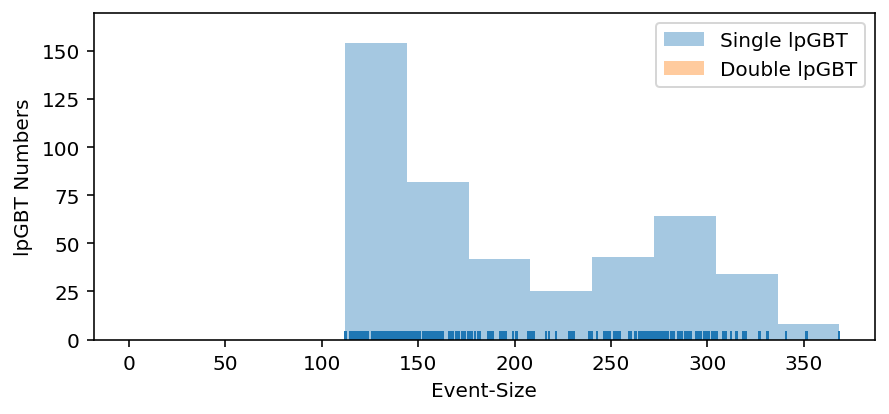

In [55]:
f, ax = plt.subplots(figsize=(7, 3))
ax.set_xlabel('Event-Size')
ax.set_ylabel("lpGBT Numbers")
sns.distplot(
    [i for i in singleGBTRates_1.values()],
    kde=False,
    rug=True,
    label='Single lpGBT'
    )
#plt.annotate('Average', xy=(Average_lpGBT_rate,0), xytext=(Average_lpGBT_rate, 30),  ha='center',
             #arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))

sns.distplot(
    [i for i in doubleGBTRates_1.values()],
    kde=False,
    rug=True,
    label='Double lpGBT'
    )
#plt.annotate('Average', xy=(avSlinkEvSize,0), xytext=(avSlinkEvSize, 30),  ha='center',
             #arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))
plt.legend()
plt.savefig("new lpgbt rate plot for thesis")



In [56]:
from dataclasses import dataclass
@dataclass
class Slink:
    totalEvSize: float
    linkList: list

from operator import attrgetter
def assign_link(link, Slinks):
    Slinks.sort(key=attrgetter('totalEvSize'))
    target = Slinks[0]
    target.linkList.append(link[0])
    target.totalEvSize += link[1]
    return Slinks

Slinks = [Slink(totalEvSize=0, linkList=[]) for _ in range(nSlinks)]
#for link in sortedLinkRates.itertuples(name='Link', index=False):
#    Slinks = assign_link(link, Slinks)

lpGBTs={}
lpGBTs.update(doubleGBTRates_1)
lpGBTs.update(singleGBTRates_1)
lpGBTs={k: v for k, v in sorted(lpGBTs.items(), key=lambda item: item[1],reverse=True)}
for link in lpGBTs.items():
    Slinks = assign_link(link, Slinks)

SlinkTotals = pd.DataFrame(data=[ Slink.totalEvSize for Slink in Slinks ], columns=['EvSize'])
#print(SlinkTotals)


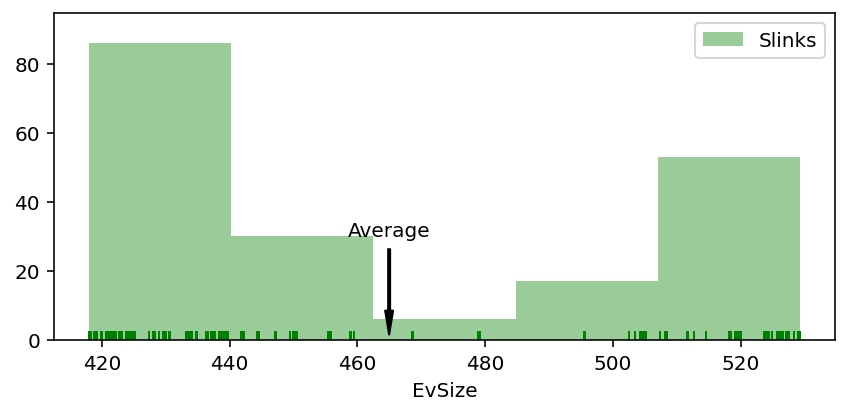

In [57]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    SlinkTotals['EvSize'],
    kde=False,
    rug=True,
    color = 'g',
    label='Slinks'
    )
plt.annotate('Average', xy=(avSlinkEvSize,0), xytext=(avSlinkEvSize, 30),  ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))
plt.legend()




In [58]:
model = pyo.ConcreteModel()

In [59]:
Single1=[str(k) for k in singleGBTRates_1.keys()]
Double1 = [str(k) for k in doubleGBTRates_1.keys()]
Slink = [str(i) for i in range(1,nSlinks+1)]
FPGA = [str(i) for i in range(1,nFPGA+1)]
#print(Single1)
#print(Double1)
#print(Slink)
#print(FPGA)


In [60]:
model.GKSingles1 = pyo.Var(Single1, Slink, initialize = 0, within = pyo.Binary)
#model.GKDoubles1 = pyo.Var(Double1, Slink, initialize = 0, within = pyo.Binary)
model.GKSlinks = pyo.Var(Slink, FPGA, initialize = 0, within = pyo.Binary)



In [61]:
if warmStart==True or hardStart==True:
    i=1
    for slink in Slinks:
        #print(slink.linkList)
        for link in slink.linkList:
            #print(link)
            if str(link) in Single1:
                model.GKSingles1[str(link),str(i)]=1
            #elif str(link) in Double1:
               # model.GKDoubles1[str(link),str(i)]=1
        i+=1


In [62]:
def SetNumberofLinks1(model, i):
    return sum([ model.GKSingles1[i, j] for j in Slink ]) == 1
    
#def SetNumberofLinks2(model, i):
    #return sum([ model.GKDoubles1[i, j] for j in Slink ]) == 1
    
def SetNumberofLinks3(model, i):
    return sum([ model.GKSlinks[i, j] for j in FPGA ]) == 1
    
model.linkCutS1 = pyo.Constraint(Single1, rule = SetNumberofLinks1)
#model.linkCutD1 = pyo.Constraint(Double1, rule = SetNumberofLinks2)
model.linkCutSK = pyo.Constraint(Slink, rule = SetNumberofLinks3)


In [63]:
def maxGBTs(model, j):
    return sum([ model.GKSingles1[i, j] for i in Single1 ]) <= maxGBTsPerSlink

def PerFPGA(model, j):   
    return sum([ model.GKSlinks[i, j] for i in Slink ]) == SlinkPerFPGA 

model.maxlpGBT = pyo.Constraint(Slink, rule = maxGBTs)
model.PerFPGA = pyo.Constraint(FPGA,  rule = PerFPGA)



In [64]:
maxGBTsPerSlink

12

In [65]:
def RateCut(model, j):   
    return sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j] for i in Single1 ])  <= maxSlinkRatePyomo 
        
model.ratelimit = pyo.Constraint(Slink, rule = RateCut)


In [66]:
GKavSlinkRate = (totalRate/nSlinks)
#print(GKavSlinkRate)


In [67]:
def OBJrule(model):
    GKslinkRatesVariance=0
    for j in Slink:
        GKslinkRates=sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j] for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j] for i in Double1 ]) 
        GKslinkRatesVariance +=  abs(GKslinkRates-GKavSlinkRate)  
    GKslinkRatesStDev = (GKslinkRatesVariance / (nSlinks-1))
    return GKslinkRatesStDev
model.objective = pyo.Objective(rule=OBJrule, sense=pyo.minimize)



In [68]:
if hardStart==False:
    #pyo.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt', tee=True)
    pyo.SolverFactory('./PyomoSolvers/couenne-linux64/couenne').solve(model, tee=False)
    #pyo.SolverFactory('./PyomoSolvers/SCIPOptSuite-7.0.1-Darwin/bin/scip').solve(model, tee=True)
    #pyo.SolverFactory('./PyomoSolvers/apopt-master/apopt.py').solve(model, tee=True) 



In [69]:
model.GKSingles1.fix()
#model.GKDoubles1.fix()


In [70]:
#with open('./ScriptRuns/'+str(nFPGA)+'lowsFPGA_run1.pkl', mode='wb+') as file:
    #cloudpickle.dump(model, file)


In [71]:
#with open('./ScriptRuns/mediums3FPGA_run2_part1.pkl', mode='rb') as file:
    #model = cloudpickle.load(file)

In [72]:
#with open('./ScriptRuns/lows28FPGA_run2_part_thershold6700.pkl', mode='rb') as file:
    #model = cloudpickle.load(file)

In [73]:
 #with open('./ScriptRuns/'+str(splitDictName)+str(nFPGA)+'312_FPGA_run2_threhold670_16h_part'+str(partNumber)+'.pkl', mode='wb+') as file:
           # cloudpickle.dump(model, file)


In [74]:
#with open('./ScriptRuns/lows16FPGA_run2_part_thershold15001 (1).pkl', mode='rb') as file:
    #model = cloudpickle.load(file)

In [75]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()


Average Slink Rate: 464.9541838541668
Std:  13.368369526614138
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 13.368369526614138


In [79]:
for splitDict,splitDictName,dictNo in zip([lowS],['lows'],['3']):
#for splitDict,splitDictName,dictNo in zip([medS, lowS],['mediums','lows'],['2','3']):
    #for partNumber in range(splitNumber):
    for partNumber in [0,1]: #range(splitNumber):
        print('-----------------------------------------------')
        # In[43]:
        if partNumber==0 and dictNo=='2':
            with open('./ScriptRuns/'+str(nFPGA)+'FPGA_run1.pkl', mode='rb') as file:
                model = cloudpickle.load(file)
        elif partNumber==0 and dictNo=='3':
        	with open('./ScriptRuns/mediums'+str(nFPGA)+'medium part_VERSİON_9'+str(splitNumber-1)+'.pkl', mode='rb') as file:
        		model = cloudpickle.load(file)
       
        else:
            with open('./ScriptRuns/'+str(splitDictName)+str(nFPGA)+'lows_version9_part'+str(partNumber-1)+'.pkl', mode='rb') as file:
                model = cloudpickle.load(file)


        # In[44]:

        
        singleGBTRates_2 =split_dict_equally(splitDict,2)[partNumber]

        print('len(singleGBTRates_2): ',len(singleGBTRates_2))
        #print(singleGBTRates_2)


        Single2=[str(k) for k in singleGBTRates_2.keys()]


        # In[46]:
        print('Doing part: ',partNumber)
        name='GKSingles'+dictNo+'_'+str(partNumber)
        model.add_component(name, pyo.Var(Single2, Slink, initialize = 0, within = pyo.Binary))
    

        #for v in model.component_data_objects(pyo.Var, active=True):
        #    print(v, pyo.value(v))  # doctest: +SKIP
        #model.pprint()
        Vars= {}
        for v in model.component_objects(pyo.Var, active=True):
            #print("Variable",v) 
            lpList=[]
            if v.name.startswith('GKSingles'):
                for index in v:
                    #print ("   ",index, pyo.value(v[index]))
                    if index[0] not in lpList:
                        lpList.append(index[0])
                    #print(index[0])
                Vars[v.name]=[lpList,v] # doctest: +SKIP

        #print(Vars,'\n')

        singleGBTRates_2_ALL={}
        for k,v in Vars.items():
            if not k.startswith('GKSingles1'):
                tempDict=medS if k.startswith('GKSingles2') else lowS
                for l in v[0]:
                    singleGBTRates_2_ALL[int(l)]=tempDict[int(l)]

        #print(singleGBTRates_2_ALL)
        Single2_ALL = [str(k) for k in singleGBTRates_2_ALL.keys()]

        totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in singleGBTRates_2_ALL.values()]))
        GKavSlinkRate = (totalRate/nSlinks)
        #maxSlinkRatePyomo = (totalRate / nSlinks)*1.8
        maxSlinkRatePyomo =1500
        print('GKavSlinkRate: ', GKavSlinkRate)
        print('maxSlinkRatePyomo: ', maxSlinkRatePyomo)



        #print(Vars)
        if partNumber!=0 or dictNo=='3':
            model.del_component(model.linkCutS2)
            model.del_component(model.linkCutS2_index)
        def SetNumberofLinks12(model, i):
            name='GKSingles'+dictNo+'_'+str(partNumber)
            return sum( [Vars[name][1][i, j] for j in Slink ]) == 1
        #def SetNumberofLinks22(model, i):
        #    return sum([ model.GKDoubles2[i, j] for j in Slink ]) == 1
        model.linkCutS2 = pyo.Constraint(Single2, rule = SetNumberofLinks12)
        #model.linkCutD2 = pyo.Constraint(Double2, rule = SetNumberofLinks22)

        model.del_component(model.maxlpGBT)
        model.del_component(model.maxlpGBT_index)
        def maxGBTs(model, j):
            GKSingles2=0
            dNL = ['2','3'] if dictNo=='3' else ['2']
            for dN in dNL:
                if dN=='2':
                    for pNo in range(8):#(partNumber+1):
                        name='GKSingles'+dN+'_'+str(pNo)
                        GKSingles2 += sum( [ Vars[name][1][i, j] for i in Vars[name][0]])
                elif dN=='3':
                    for pNo in range(partNumber+1):
                        name='GKSingles'+dN+'_'+str(pNo)
                        GKSingles2 += sum( [ Vars[name][1][i, j] for i in Vars[name][0]])
            return sum([ model.GKSingles1[i, j].value for i in Single1]) + GKSingles2  <= maxGBTsPerSlink
        model.maxlpGBT = pyo.Constraint(Slink, rule = maxGBTs)
        
      

        model.del_component(model.ratelimit)
        model.del_component(model.ratelimit_index)
        def RateCut(model, j):   
            GKSingles2=0
            dNL = ['2','3'] if dictNo=='3' else ['2']
            for dN in dNL:
                if dN=='2':
                    for pNo in range(8):#(partNumber+1):
                        name='GKSingles'+dN+'_'+str(pNo)
                        GKSingles2 += sum( [singleGBTRates_2_ALL[int(i)]*Vars[name][1][i, j] for i in Vars[name][0] ])
                elif dN=='3':
                    for pNo in range(partNumber+1):
                        name='GKSingles'+dN+'_'+str(pNo)
                        GKSingles2 += sum( [singleGBTRates_2_ALL[int(i)]*Vars[name][1][i, j] for i in Vars[name][0] ])
                        
            return (1 , sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j] for i in Single1])+ GKSingles2 , maxSlinkRatePyomo ) 
        model.ratelimit = pyo.Constraint(Slink, rule = RateCut)

        model.del_component(model.objective)
        def OBJrule(model):
            GKslinkRatesVariance=0
            for j in Slink:
                GKSingles2=0
                c=0
                dNL = ['2','3'] if dictNo=='3' else ['2']
                for dN in dNL:
                    if dN=='2':
                        for pNo in range(8): #(partNumber+1):
                            c+=1
                            name='GKSingles'+dN+'_'+str(pNo)
                            GKSingles2 += sum( [singleGBTRates_2_ALL[int(i)]*Vars[name][1][i, j] for i in Vars[name][0] ])
                    elif dN=='3':
                        for pNo in range(partNumber+1):
                            c+=1
                            name='GKSingles'+dN+'_'+str(pNo)
                            GKSingles2 += sum( [singleGBTRates_2_ALL[int(i)]*Vars[name][1][i, j] for i in Vars[name][0] ])
                            
                GKslinkRates=sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j] for i in Single1])+ GKSingles2  
                GKslinkRatesVariance +=  abs(GKslinkRates-GKavSlinkRate)
            GKslinkRatesStDev = (GKslinkRatesVariance / (nSlinks-1))
            return GKslinkRatesStDev
        model.objective = pyo.Objective(rule=OBJrule, sense=pyo.minimize)


        # In[47]:


        #model.pprint()


        # In[49]:


        #pyo.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt', tee=True)
        pyo.SolverFactory('./PyomoSolvers/couenne-linux64/couenne').solve(model, tee=False)
        #pyo.SolverFactory('./PyomoSolvers/SCIPOptSuite-7.0.1-Darwin/bin/scip').solve(model, tee=True)
        #pyo.SolverFactory('./PyomoSolvers/apopt-master/apopt.py').solve(model, tee=True)


        # In[50]:
        name='GKSingles'+dictNo+'_'+str(partNumber)
        for i in Vars[name][0]:
            sumLink=0
            for j in Slink:
                sumLink+=Vars[name][1][i,j].value
            if sumLink!=1:
                print('Error! Not all lpGBTs are linked!')
                sys.exit()


        # In[51]:


        Vars[name][1].fix()


        # In[52]:


        with open('./ScriptRuns/'+str(splitDictName)+str(nFPGA)+'lows_version9_part'+str(partNumber)+'.pkl', mode='wb+') as file:
            cloudpickle.dump(model, file)


-----------------------------------------------
len(singleGBTRates_2):  226
Doing part:  0


RuntimeError: Cannot add component 'GKSingles3_0' (type <class 'pyomo.core.base.var.IndexedVar'>) to block 'unknown': a component by that name (type <class 'pyomo.core.base.var.IndexedVar'>) is already defined.

In [40]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()



Average Slink Rate: 800.4831285416664
Std:  13.368369526614138
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 13.368369526614138
